<a href="https://colab.research.google.com/github/M00NBOW/Impacto-da-Pandemia-no-Setor-de-Tecnologia/blob/main/CodigoUSPversaoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%pip install pysentimiento

In [41]:
# =========================
# 1. Importações
# =========================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import RandomOverSampler
from pysentimiento import create_analyzer
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("vader_lexicon")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [42]:
# =========================
# 2. Carregar dataset
# =========================
base_df = pd.read_csv("/content/Impacto da Pandemia no Setor de Tecnologia Pesquisa sobre Condições de Trabalho.csv")

# Selecionar apenas respostas abertas
colunas_texto = base_df.iloc[:, 6:]
respostas = colunas_texto.fillna("").applymap(str).values.flatten()
respostas = [r for r in respostas if r.strip() != ""]

respostas_df = pd.DataFrame(respostas, columns=["registro"])

/tmp/ipython-input-2326884251.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  respostas = colunas_texto.fillna("").applymap(str).values.flatten()


In [43]:
# =========================
# 3. Pré-processamento
# =========================
def is_special(texto):
    rem = ""
    for i in texto:
        if i.isalnum():
            rem += i
        else:
            rem += " "
    return rem

def to_lower(texto):
    return texto.lower()

def remover_stopwords(texto):
    stop_words = set(stopwords.words("portuguese"))
    palavras = word_tokenize(texto)
    return [palavra for palavra in palavras if palavra not in stop_words]

def stemming(tokens):
    stemmer = SnowballStemmer("portuguese")
    return " ".join([stemmer.stem(palavra) for palavra in tokens])


In [44]:
# =========================
# 4. Rotulagem automática com VADER
# =========================
sia = SentimentIntensityAnalyzer()

def classificar_sentimento(texto):
    if isinstance(texto, list):
        texto = " ".join(texto)
    polaridade = sia.polarity_scores(texto)["compound"]
    if polaridade > 0.05:
        return "positivo"
    elif polaridade < -0.05:
        return "negativo"
    else:
        return "neutro"

# Criar rótulos automáticos
#respostas_df["sentimento"] = respostas_df["registro"].apply(classificar_sentimento)


In [45]:
# Criar analisador de sentimentos em português
analyzer = create_analyzer(task="sentiment", lang="pt")

# Gerar rótulos com pysentimiento
def classificar_sentimento_pysentimiento(texto):
    if isinstance(texto, list):
        texto = " ".join(texto)
    resultado = analyzer.predict(texto)
    return resultado.output  # retorna "POS", "NEG" ou "NEU"

# Aplicar no dataframe
respostas_df["sentimento"] = respostas_df["registro"].apply(classificar_sentimento_pysentimiento)

# Ajustar para português amigável
respostas_df["sentimento"] = respostas_df["sentimento"].replace({
    "POS": "Bem-estar melhorado",
    "NEG": "Bem-estar prejudicado",
    "NEU": "Sem impacto percebido"
})

print("Distribuição de sentimentos:", respostas_df["sentimento"].value_counts())
respostas_df.head()

Distribuição de sentimentos: sentimento
Sem impacto percebido    219
Bem-estar prejudicado    107
Bem-estar melhorado       49
Name: count, dtype: int64


,registro,sentimento
0,Ao meu ver é uma forma de nos preparar um pouc...,Sem impacto percebido
1,Com todas essas tecnologias eu percebi que o m...,Sem impacto percebido
2,Minha vida pessoal perdeu muito espaço para a ...,Bem-estar prejudicado
3,Meu stress chegou num ponto onde eu não suport...,Bem-estar prejudicado
4,"Eles nos tratam como se fossemos crianças, não...",Bem-estar prejudicado


In [46]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [47]:
# =========================
# 5. Modelo supervisionado com scikit-learn
# =========================
stop_words_portuguese = set(stopwords.words("portuguese"))

# Pré-processamento
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=5000
)
X = vectorizer.fit_transform(respostas_df["registro"].astype(str))
y = respostas_df["sentimento"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balanceamento de classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

#Modelo supervisionado
modelo = LogisticRegression(max_iter=1000)
#modelo = LinearSVC(class_weight="balanced"
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)


Acurácia: 0.6902654867256637

Relatório de Classificação:

                       precision    recall  f1-score   support

  Bem-estar melhorado       0.67      0.29      0.40        14
Bem-estar prejudicado       0.57      0.59      0.58        29
Sem impacto percebido       0.74      0.81      0.78        70

             accuracy                           0.69       113
            macro avg       0.66      0.56      0.58       113
         weighted avg       0.69      0.69      0.68       113



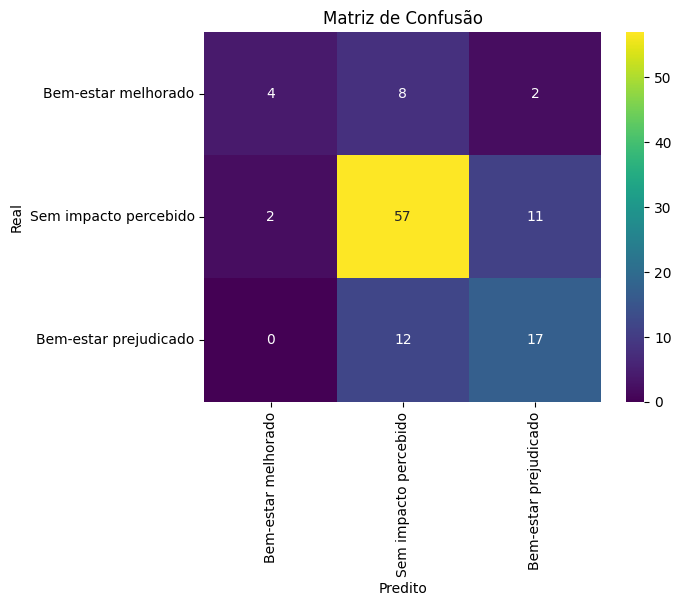

In [48]:
# Vetorização
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(respostas_df["registro"].astype(str))
y = respostas_df["sentimento"]

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo supervisionado
modelo = LogisticRegression(max_iter=1000, class_weight="balanced")
modelo.fit(X_train, y_train)

# Predições
y_pred = modelo.predict(X_test)

# Avaliação
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Bem-estar melhorado", "Sem impacto percebido", "Bem-estar prejudicado"])
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=["Bem-estar melhorado", "Sem impacto percebido", "Bem-estar prejudicado"],
            yticklabels=["Bem-estar melhorado", "Sem impacto percebido", "Bem-estar prejudicado"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()
